# Predictor trained on experimental DMS data to distinguish damaging from neutral mutations

## Setup

* Data: experimental DMS for all possible AA substitution generated by single nucleotide change
* Feature vector: each variant is a **58-element vector** - 
  + **WT Amino acid** (one-hot encoding) [*20 features*]
  + **MUT Amino Acid** (one-hot encoding) [*20 features*]
  + **trinucleotide context**
    * position -1 (one-hot encoding) [*4 features*]
    * position 0 (6 possible substitutions, one-hot encoding) [*6 features*]
    * position +1 (one-hot encoding) [*4 features*]
  + phyloP **conservation score** [separately for positions -1, 0, 1] [*3 features*]
  + **Q(SASA)** [1 feature]
  
## Data source

* [MAVEdb](https://www.mavedb.org/) for all DMS experiments to assay human proteins with an UniProt accession ID mapped in the MAVEdb database. I manually go through descriptions of these datasets to identify a set of non-redundant datasets:
  + Some of them are assaying the same protein but under different conditions (e.g. chemical perturbations) - in these cases only 1 is selected (either the control experiment without perturbation, or if the associated publication has a dedicated processing method to derive a score that summarises behaviours across different conditions)
* Total **27 datasets** used for training & internal validation of the prediction. Here do some exploratory work.

### Notes
* The different score sets have different scales and rules, e.g. some denote damaging variants with a high/positive score, some with a low/negative score. I manually go through the descriptions on MAVEdb and/or the associated publications and annotated accordingly. (*All noted down in a spreadsheet `mapping_annotated.xlsx`*) Need to standardise this so that **the lower a score, the more damaging the variant**.
* Still it is likely that because the ranges of values in each dataset are different (and that certain proteins in certain experiments simply have a specific distribution of damaging vs neutral variants), it is difficult to find a way to standardise this so that all values strictly follow the same distribution. **Therefore we do the following:**
  + Individually for each score set, performs K-means clustering to separate the data points into 2 clusters. By visual inspection of the distributions most of them have a bimodal distribution so `K = 2` seems reasonable.
  + Identify the cluster with higher mean score as 'neutral' set and the cluster with lower mean score as 'damaging' set. These binary labels are the 'Y' labels in the prediction using the feature vectors 'X' as detailed above.

In [1]:
%load_ext rpy2.ipython

In [2]:
import numpy as np
import pandas as pd
import re
import pickle

In [3]:
# read in data
dms_exp = pd.read_csv('data/MAVEdb/human_proteins.csv')


In [4]:
dms_exp

,hgvs_pro,score,scoreset,uniprot,WT_AA,MUT_AA,AA_pos
0,p.Val15His,1.549447,urn:mavedb:00000041-a-1,P12931,V,H,284
1,p.Val15Gly,1.266378,urn:mavedb:00000041-a-1,P12931,V,G,284
2,p.Val15Glu,1.481810,urn:mavedb:00000041-a-1,P12931,V,E,284
3,p.Val15Gln,1.372176,urn:mavedb:00000041-a-1,P12931,V,Q,284
4,p.Val15Cys,1.013863,urn:mavedb:00000041-a-1,P12931,V,C,284
...,...,...,...,...,...,...,...
1108743,p.Pro656Cys,1.875000,urn:mavedb:00000049-a-1,P42898,P,C,656
1108744,p.Pro656=,NaN,urn:mavedb:00000049-a-1,P42898,P,P,656
1108745,p.Pro656Gly,NaN,urn:mavedb:00000049-a-1,P42898,P,G,656
1108746,p.Pro656Met,NaN,urn:mavedb:00000049-a-1,P42898,P,M,656


In [5]:
# filter for the datasets to be considered
with open('data/MAVEdb/scoresets_to_use', 'r') as r:
    scoreset_include = [id.rstrip() for id in r.readlines()]

dms_exp = dms_exp[dms_exp['scoreset'].isin(scoreset_include)]
dms_exp.shape

(153284, 7)

In [6]:
dms_exp.applymap(type).apply(set)

hgvs_pro      {<class 'str'>}
score       {<class 'float'>}
scoreset      {<class 'str'>}
uniprot       {<class 'str'>}
WT_AA         {<class 'str'>}
MUT_AA        {<class 'str'>}
AA_pos        {<class 'str'>}
dtype: object

/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "hgvs_pro". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  warnings.warn('Error while trying to convert '
/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "scoreset". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  warnings.warn('Error while trying to convert '
/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "uniprot". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  warnings.warn('Error while trying to convert '
/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "WT_AA". Fall back to string c

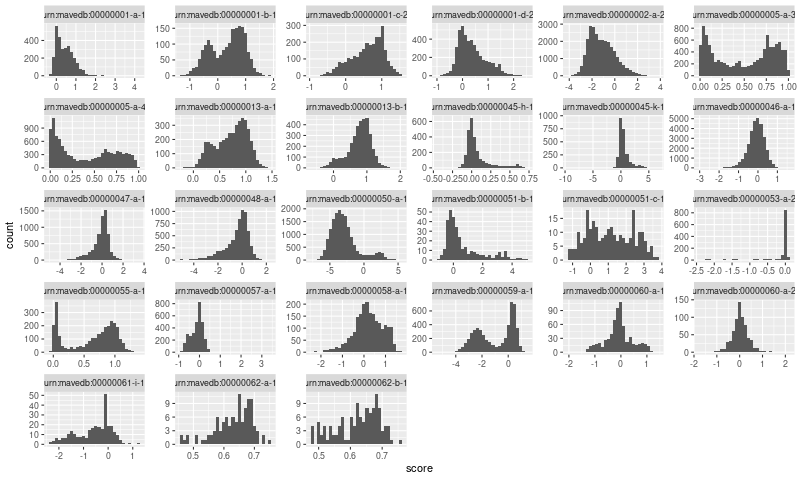

In [7]:
%%R -i dms_exp -w 800 --type=cairo

library(ggplot2)
# Histogram of 'score' separately for each scoreset
ggplot(data = dms_exp) + geom_histogram(aes(score)) + facet_wrap(~ scoreset, scales = "free")

Each grid is one individual dataset. Most of the distributions are bimodal. Two issues:

* Those which are not bimodal - should remove from consideration?
* Needs ways to address imbalanced dataset (way more neutral variants than damaging, or the other way round) in training/testing the predictor.

In [8]:
# scoreset_remove - those which are not bimodal by visual inspection above
scoreset_remove = ['urn:mavedb:00000001-c-2', 'urn:mavedb:00000001-d-2', 'urn:mavedb:00000001-a-1', \
                   'urn:mavedb:00000002-a-2', 'urn:mavedb:00000045-h-1', 'urn:mavedb:00000045-k-1', \
                   'urn:mavedb:00000046-a-1', \
                   'urn:mavedb:00000047-a-1', 'urn:mavedb:00000048-a-1', 'urn:mavedb:00000051-c-1', \
                   'urn:mavedb:00000053-a-2', 'urn:mavedb:00000060-a-1', 'urn:mavedb:00000060-a-2',\
                   'urn:mavedb:00000061-i-1', 'urn:mavedb:00000062-a-1', 'urn:mavedb:00000062-b-1']
smaller_set = [i for i in scoreset_include if i not in scoreset_remove]
dms_exp_retain = dms_exp[dms_exp['scoreset'].isin(smaller_set)]
dms_exp_retain

,hgvs_pro,score,scoreset,uniprot,WT_AA,MUT_AA,AA_pos
53080,p.Met1Ala,-0.079522,urn:mavedb:00000050-a-1,P43246,M,A,1
53081,p.Met1Cys,NaN,urn:mavedb:00000050-a-1,P43246,M,C,1
53082,p.Met1Tyr,-2.870684,urn:mavedb:00000050-a-1,P43246,M,Y,1
53083,p.Met1Trp,-3.991671,urn:mavedb:00000050-a-1,P43246,M,W,1
53084,p.Met1Val,-1.395361,urn:mavedb:00000050-a-1,P43246,M,V,1
...,...,...,...,...,...,...,...
1062816,p.Pro6Asp,0.617044,urn:mavedb:00000005-a-4,P35520,P,D,6
1062817,p.Pro6Arg,0.120909,urn:mavedb:00000005-a-4,P35520,P,R,6
1062818,p.Pro6Val,0.107902,urn:mavedb:00000005-a-4,P35520,P,V,6
1062819,p.Pro6Ala,0.412779,urn:mavedb:00000005-a-4,P35520,P,A,6


In [9]:
# the experiments which remain and the proteins which they are mapped to
dms_exp_retain[["scoreset", "uniprot"]].drop_duplicates()


,scoreset,uniprot
53080,urn:mavedb:00000050-a-1,P43246
118960,urn:mavedb:00000013-b-1,P51580
184064,urn:mavedb:00000058-a-1,P05067
246658,urn:mavedb:00000013-a-1,P60484
272121,urn:mavedb:00000059-a-1,P04637
339105,urn:mavedb:00000057-a-1,P01112
342240,urn:mavedb:00000055-a-1,Q9NV35
349933,urn:mavedb:00000005-a-3,P35520
1027063,urn:mavedb:00000051-b-1,P04626
1050452,urn:mavedb:00000001-b-1,P63165


11 experiments on 10 proteins. Sounds very few but still >62k variants.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



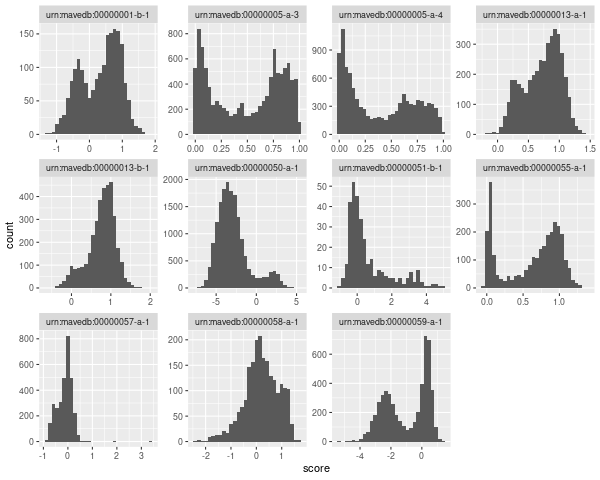

In [10]:
%%R -i dms_exp_retain -w 600 --type=cairo

library(ggplot2)
# Histogram of 'score' separately for each scoreset retained 
# (ie those for the predictor + the holdout datasets)
ggplot(data = dms_exp_retain) + geom_histogram(aes(score)) + facet_wrap(~ scoreset, scales = "free")

### K-means clustering

Use scikit-learn function `sklearn.cluster.KMeans`

In [11]:
from sklearn.cluster import KMeans

def doKMeans2(data):
    """
    Given 'data', perform K-means clustering to yield 2 clusters.
    Label the cluster with higher mean value as '0' and the one with lower mean value is '1'
    Input:
        - data: pd.Series ie one column in the pd DataFrame
    Return:
        np.array of labels in [0, 1]
    """
    data = np.array(data).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=123).fit(data)
    labels = kmeans.labels_
    # check mean value
    means = [np.mean([val for i, val in enumerate(data) if labels[i] == j]) for j in [0, 1]]
    if means[0] < means[1]:
        # swap labels
        labels2 = []
        for i, k in enumerate(labels):
            if k == 0:
                labels2.append(1)
            elif k == 1:
                labels2.append(0)
        labels = labels2
    return labels

In [12]:
# a dictionary of DataFrames splitting by 'scoreset'
ms_exp_dict = {scoreset: dms_exp[dms_exp['scoreset'] == scoreset].copy() for scoreset in smaller_set}

# these datasets the scores need inverting (i.e. transform by x * -1) so that lower score means more damaging
invert = ['urn:mavedb:00000051-b-1', 'urn:mavedb:00000050-a-1']

dms_exp_labelled = pd.DataFrame()
for scoreset, db in dms_exp_dict.items():
    db = db.copy()
    db = db[ ~ db['score'].isna() ]
    if scoreset in invert:
        db['score'] *= -1
    kmeans_labels = doKMeans2(db['score'])
    db['label'] = pd.DataFrame(kmeans_labels, index = db.index)
    dms_exp_labelled = pd.concat([dms_exp_labelled, db])


In [13]:
dms_exp_labelled

,hgvs_pro,score,scoreset,uniprot,WT_AA,MUT_AA,AA_pos,label
1050452,p.Glu5Lys,1.311357,urn:mavedb:00000001-b-1,P63165,E,K,5,0
1050453,p.Arg70Asn,0.914786,urn:mavedb:00000001-b-1,P63165,R,N,70,0
1050454,p.Val101Gly,0.441670,urn:mavedb:00000001-b-1,P63165,V,G,101,0
1050455,p.Arg54His,-0.426582,urn:mavedb:00000001-b-1,P63165,R,H,54,1
1050456,p.Asp15Val,0.876463,urn:mavedb:00000001-b-1,P63165,D,V,15,0
...,...,...,...,...,...,...,...,...
277372,p.Thr1His,-2.277664,urn:mavedb:00000059-a-1,P04637,T,H,102,1
277373,p.Thr1Met,-3.400709,urn:mavedb:00000059-a-1,P04637,T,M,102,1
277374,p.Thr1Arg,-2.973493,urn:mavedb:00000059-a-1,P04637,T,R,102,1
277375,p.Thr1Lys,-2.224744,urn:mavedb:00000059-a-1,P04637,T,K,102,1


Plot again to inspect how the clustering performs?

/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "hgvs_pro". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  warnings.warn('Error while trying to convert '
/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "scoreset". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  warnings.warn('Error while trying to convert '
/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "uniprot". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  warnings.warn('Error while trying to convert '
/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "WT_AA". Fall back to string c

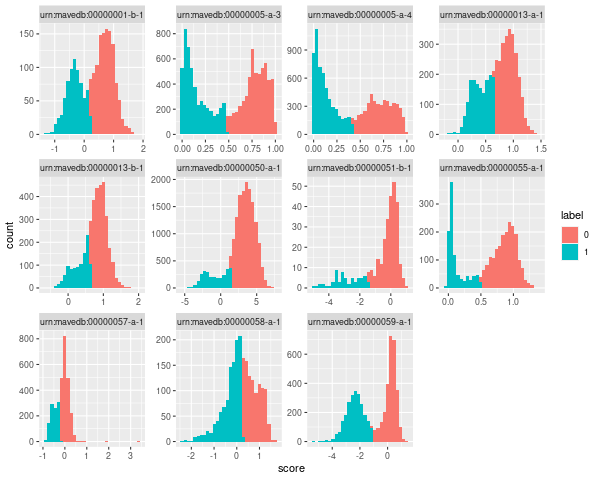

In [14]:
%%R -i dms_exp_labelled -w 600 --type=cairo

library(ggplot2)
# Histogram of 'score' separately for each scoreset retained 
# (ie those for the predictor + the holdout datasets)
dms_exp_labelled$label <- factor(dms_exp_labelled$label, levels = c(0, 1))
ggplot(data = dms_exp_labelled) + geom_histogram(aes(score, fill = label)) + 
  facet_wrap(~ scoreset, scales = "free")

In [15]:
# write out the list of UniProt IDs to fetch for information (see below)
uniprots = list(set(dms_exp_labelled['uniprot']))
uniprots
with open('data/MAVEdb/human_proteins_retained_uniprot', 'w') as w:
    for u in uniprots:
        w.write(u + '\n')

# write out table
dms_exp_labelled.to_csv('data/MAVEdb/human_proteins_retained.csv', index=False)

### Annotate features

* QSASA: Taken from ZoomVar
* MutSig, PhyloP scores: Use CDSMutSig and the phyloP bioconductor packages (adapted from Marija's code) in R

In [16]:
%%bash

# ZoomVar
head -1 $HOME/Documents/ZoomvarTCGA/protein_position_annotations_zoomvar_category_NEW.tsv > data/MAVEdb/human_proteins_retained_ZoomVar.tsv
while read uniprot; do
    grep -E "^"$uniprot $HOME/Documents/ZoomvarTCGA/protein_position_annotations_zoomvar_category_NEW.tsv >> data/MAVEdb/human_proteins_retained_ZoomVar.tsv
done < 'data/MAVEdb/human_proteins_retained_uniprot'

In [17]:
%%R -o mutsigs
# Map genomic position, MutSig and phyloP scores

ensp <- data.frame(
  uniprot_id = c("Q9NV35", "P04626", "P05067", "P01112", "P35520", "P04637",
                 "P63165", "P43246", "P51580", "P60484"),
  protein_id = c("ENSP00000258662", "ENSP00000269571", "ENSP00000284981", "ENSP00000407586",
                 "ENSP00000381231", "ENSP00000269305", "ENSP00000376077", "ENSP00000233146",
                 "ENSP00000312304", "ENSP00000361021"), # manually confirmed by searching Ensembl 
  stringsAsFactors = FALSE
)

# Use CDSMutSig
library(CDSMutSig)
mutsigs <- lapply(ensp$protein_id, function(id){
  cat(paste0(id, " ...\n"))
  codons <- mapCodon(id, EnsDb.Hsapiens.v86::EnsDb.Hsapiens.v86,
                     BSgenome.Hsapiens.NCBI.GRCh38::Hsapiens, 
                     seqLevelStyle = "NCBI")
  if( is.null( codons ) ) return(NULL)
  codons_muts <- mapMut(codons, getPossibleMissenseSNVs())
  codons_mutsigs <- mapMutSig(id, nrow(codons), codons_muts, 
                              EnsDb.Hsapiens.v86::EnsDb.Hsapiens.v86,
                              BSgenome.Hsapiens.NCBI.GRCh38::Hsapiens, 
                              seqLevelStyle = "NCBI")
  codons_mutsigs$ensp <- id  
  codons_mutsigs
})
       
mutsigs <- do.call("rbind", mutsigs)
mutsigs <- merge( ensp, mutsigs, by.x = "protein_id", by.y = "ensp" )
write.table(mutsigs, 'data/MAVEdb/human_proteins_retained_MutSig.tsv', sep = "\t",
            col.names = TRUE, row.names = FALSE, quote = FALSE)

ENSP00000258662 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000269571 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000284981 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000407586 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000381231 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000269305 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000376077 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000233146 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000312304 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000361021 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



In [18]:
%%R -i mutsigs -o PhyloP

# Use PhyloP                                  
library(GenomicRanges)
library(GenomicScores)
library(IRanges)
library(stringr)

phast <- getGScores("phyloP100way.UCSC.hg38")

PhyloP <- sapply(-1:1, function(x){
  gscores_phylop <- gscores(phast,
        GenomicRanges::GRanges(seqnames = paste0("chr", mutsigs[, "chr"]),
                               ranges = IRanges::IRanges(
                               start = mutsigs[, "g_pos"] + x,
                               end = mutsigs[, "g_pos"] + x)))
  gscores_phylop <- as.data.frame(gscores_phylop)
  return( gscores_phylop[, 6] )
})

colnames( PhyloP ) <- paste("PhyloP", -1:1, sep = "_")
PhyloP <- as.data.frame(PhyloP)


/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "protein_id". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  warnings.warn('Error while trying to convert '
/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "uniprot_id". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  warnings.warn('Error while trying to convert '
/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "chr". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  warnings.warn('Error while trying to convert '
/home/josefng/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "WT_AA". Fall back to string c

In [19]:
mutsigs = pd.concat([mutsigs, PhyloP], axis = 1)
mutsigs

,protein_id,uniprot_id,chr,g_pos,AA_pos,WT_AA,MUT_AA,WT_codon,MUT_codon,MutSig,PhyloP_-1,PhyloP_0,PhyloP_1
1,ENSP00000233146,P43246,2,47403193.0,1,M,T,ATG,ACG,A[T>C]G,8.0,5.0,7.0
2,ENSP00000233146,P43246,2,47403192.0,1,M,L,ATG,TTG,A[T>A]G,1.0,8.0,5.0
3,ENSP00000233146,P43246,2,47403193.0,1,M,K,ATG,AAG,A[T>A]G,8.0,5.0,7.0
4,ENSP00000233146,P43246,2,47403193.0,1,M,R,ATG,AGG,A[T>G]G,8.0,5.0,7.0
5,ENSP00000233146,P43246,2,47403192.0,1,M,L,ATG,CTG,A[T>G]G,1.0,8.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34903,ENSP00000407586,P01112,11,532753.0,189,S,A,TCC,GCC,C[T>G]C,6.0,-1.5,4.0
34904,ENSP00000407586,P01112,11,532753.0,189,S,T,TCC,ACC,C[T>A]C,6.0,-1.5,4.0
34905,ENSP00000407586,P01112,11,532754.0,189,S,F,TCC,TTC,T[C>T]C,-1.5,4.0,5.0
34906,ENSP00000407586,P01112,11,532754.0,189,S,Y,TCC,TAC,T[C>A]C,-1.5,4.0,5.0


In [20]:
mutsigs['AA_pos'] = mutsigs['AA_pos'].astype(str)
mutsigs.to_csv('data/MAVEdb/human_proteins_retained_MutSig_PhyloP.tsv', sep="\t", index=False)


In [21]:
# the zoomvar Q(SASA) information
zoomvar = pd.read_csv('data/MAVEdb/human_proteins_retained_ZoomVar.tsv', sep = "\t", index_col=False)
zoomvar = zoomvar[['protein', 'position', 'Q(SASA)']]
zoomvar['position'] = zoomvar['position'].astype(str)

In [22]:
# merge this to the dms_exp_labelled df
dms_exp_labelled = pd.merge( dms_exp_labelled, mutsigs, \
                             left_on = ["uniprot", "AA_pos", "WT_AA", "MUT_AA"], \
                             right_on = ["uniprot_id", "AA_pos", "WT_AA", "MUT_AA"])

dms_exp_labelled = pd.merge( dms_exp_labelled, zoomvar, left_on = ['uniprot', 'AA_pos'], \
                             right_on = ['protein', 'position'])

In [23]:
dms_exp_labelled

,hgvs_pro,score,scoreset,uniprot,WT_AA,MUT_AA,AA_pos,label,protein_id,uniprot_id,...,g_pos,WT_codon,MUT_codon,MutSig,PhyloP_-1,PhyloP_0,PhyloP_1,protein,position,Q(SASA)
0,p.Glu5Lys,1.311357,urn:mavedb:00000001-b-1,P63165,E,K,5,0,ENSP00000376077,P63165,...,202220032.0,GAG,AAG,T[C>T]C,7.0,7.0,7.0,P63165,5,0.7627
1,p.Glu5Val,1.058888,urn:mavedb:00000001-b-1,P63165,E,V,5,0,ENSP00000376077,P63165,...,202220033.0,GAG,GTG,C[T>A]C,7.0,7.0,9.0,P63165,5,0.7627
2,p.Glu5Gly,1.163638,urn:mavedb:00000001-b-1,P63165,E,G,5,0,ENSP00000376077,P63165,...,202220033.0,GAG,GGG,C[T>C]C,7.0,7.0,9.0,P63165,5,0.7627
3,p.Glu5Gln,0.989726,urn:mavedb:00000001-b-1,P63165,E,Q,5,0,ENSP00000376077,P63165,...,202220032.0,GAG,CAG,T[C>G]C,7.0,7.0,7.0,P63165,5,0.7627
4,p.Glu5Ala,0.974093,urn:mavedb:00000001-b-1,P63165,E,A,5,0,ENSP00000376077,P63165,...,202220033.0,GAG,GCG,C[T>G]C,7.0,7.0,9.0,P63165,5,0.7627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21642,p.Thr1Ser,-3.252553,urn:mavedb:00000059-a-1,P04637,T,S,102,1,ENSP00000269305,P04637,...,7676202.0,ACC,AGC,A[C>G]C,0.5,1.5,0.5,P04637,102,0.5294
21643,p.Thr1Ser,-2.737670,urn:mavedb:00000059-a-1,P04637,T,S,102,1,ENSP00000269305,P04637,...,7676201.0,ACC,TCC,G[T>A]T,-0.5,0.5,1.5,P04637,102,0.5294
21644,p.Thr1Ser,-2.737670,urn:mavedb:00000059-a-1,P04637,T,S,102,1,ENSP00000269305,P04637,...,7676202.0,ACC,AGC,A[C>G]C,0.5,1.5,0.5,P04637,102,0.5294
21645,p.Thr1Ala,-2.521949,urn:mavedb:00000059-a-1,P04637,T,A,102,1,ENSP00000269305,P04637,...,7676201.0,ACC,GCC,G[T>C]T,-0.5,0.5,1.5,P04637,102,0.5294


In [24]:
# remove those with QSASA nan
dms_exp_labelled = dms_exp_labelled[ dms_exp_labelled['Q(SASA)'].str.find('None') == -1 ]
dms_exp_labelled.to_csv('data/MAVEdb/human_proteins_retained_ready.tsv', sep = "\t", index=False)


In [25]:
dms_exp_labelled.shape

(20352, 21)

# Envision variants

Test our predictors against [Envision](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5799033/). Looked for DMS datasets in MAVEdb which were NOT used in training BOTH Envision and our DMSexp predictor.

Envision is a regression model and DMSexp a classification model. For fair comparison here merge the MAVEdb datasets and harmonise the scores. Using the [deepscanscape](https://www.embopress.org/doi/full/10.15252/msb.202110305) R package.

### Merge test set



In [26]:
%%R

library(deepscanscape)

# merging MAVEdb datasets as test cases for DMSexp and Envision

# list of MAVEdb IDs
ids <- c("urn_mavedb_00000001-a-4", "urn_mavedb_00000001-d-1", "urn_mavedb_00000035-a-1",
         "urn_mavedb_00000036-a-1", "urn_mavedb_00000041-a-1", "urn_mavedb_00000041-b-1")
dms <- list()

mavedb <- lapply(ids, function(x){
  o <- read.csv(paste0("data/MAVEdb/", x, ".csv"), skip = 4)
  # remove NA scores, double/triple mutants
  o <- o[!grepl(";", o$hgvs_pro), ]
  o <- o[!is.na(o$score), ]
})
dms$ube2i <- deep_mutational_scan(mavedb[[1]], name = "UBE2i", gene = 'UBE2i', study = 'Weile et al. (2017)',
                                  scheme = "mavedb", trans = "vamp-seq", na_value = 'average', duplicates = "mean",
                                  average_multi = TRUE)
dms$tpk1 <- deep_mutational_scan(mavedb[[2]], name = "TPK1", gene = 'TPK1', study = 'Weile et al. (2017)',
                                  scheme = "mavedb", trans = "vamp-seq", na_value = 'average', duplicates = "mean",
                                  average_multi = TRUE)
dms$hmgcr <- deep_mutational_scan(mavedb[[3]], name = "HMGCR", gene = 'HMGCR', study = '?',
                                 scheme = "mavedb", trans = "vamp-seq", na_value = 'average', duplicates = "mean",
                                 average_multi = TRUE)
dms$ldlrap1 <- deep_mutational_scan(mavedb[[4]], name = "LDLRAP1", gene = 'LDLRAP1', study = '?',
                                  scheme = "mavedb", trans = "vamp-seq", na_value = 'average', duplicates = "mean",
                                  average_multi = TRUE)
# this dataset already in the log2 space. use 'invert' as higher score indicates weaker activity
dms$src_kin <- deep_mutational_scan(mavedb[[5]], name = "SRC_kin", gene = 'SRC', study = 'Ahler et al. (2019)',
                                    scheme = "mavedb", trans = "invert", na_value = 'average', duplicates = "mean",
                                    average_multi = TRUE, position_offset = 269)
# this dataset already in the log2 space. use 'invert' as higher score indicates weaker activity
dms$src_sh <- deep_mutational_scan(mavedb[[6]], name = "SRC_sh", gene = 'SRC', study = 'Ahler et al. (2019)',
                                    scheme = "mavedb", trans = "invert", na_value = 'average', duplicates = "mean",
                                    average_multi = TRUE, position_offset = 1)


# combine datasets
dms <- bind_scans(dms)
dms <- as.data.frame(dms)
dms <- reshape2::melt(dms, id.vars = c("name", "position", "wt"),
                      measure.vars = colnames(dms)[4:23])
mapping <- data.frame("name" = c("UBE2i", "TPK1", "HMGCR", "LDLRAP1", "SRC_kin", "SRC_sh"),
                      "uniprot" = c("P63279", "Q9H3S4", "P04035", "Q5SW96", "P12931", "P12931"),
                      stringsAsFactors = FALSE)
dms <- merge(dms, mapping, by = "name")
write.table(dms, "../Envision/Envision_MAVEdb_test_set.csv",
            sep = "\t", row.names = FALSE, col.names = TRUE)


In [27]:
envision = [pd.read_csv('../Envision/P04035_envisionData.csv'), \
            pd.read_csv('../Envision/P12931_envisionData.csv'), \
            pd.read_csv('../Envision/P63279_envisionData.csv'), \
            pd.read_csv('../Envision/Q5SW96_envisionData.csv'),\
            pd.read_csv('../Envision/Q9H3S4_envisionData.csv')]

In [28]:
envision = pd.concat(envision)
envision.to_csv('../Envision/Envision_predictions.csv')

In [29]:
%%R -o mutsigs
# Map genomic position, MutSig and phyloP scores

ensp <- ensembldb::proteins( EnsDb.Hsapiens.v86::EnsDb.Hsapiens.v86,
                     filter = AnnotationFilter::UniprotFilter(c("P04035", "P12931", "P63279", "Q5SW96", "Q9H3S4")),
                     columns = c("uniprot_id", "protein_id"))
# select only transcripts in MANE
MANE <- read.table(file = "../../MANE.GRCh38.v0.93.summary.txt.gz", sep = "\t", 
                   header = TRUE, comment.char = '', stringsAsFactors = FALSE, quote = '')
MANE$EnsProtID <- sapply(MANE$Ensembl_prot, function(x) unlist(strsplit(x, split = ".", fixed = TRUE))[1] )

Ensembl_MANE <- merge(ensp, MANE[, c(4, ncol(MANE))], by.x = "protein_id", by.y = "EnsProtID", all.x = TRUE)
Ensembl_MANE <- Ensembl_MANE[ which(!is.na(Ensembl_MANE[, "symbol"])), ]
print(head(Ensembl_MANE))
print(summary(Ensembl_MANE))
                         
# Use CDSMutSig
library(CDSMutSig)
mutsigs <- lapply(Ensembl_MANE$protein_id, function(id){
  cat(paste0(id, " ...\n"))
  codons <- mapCodon(id, EnsDb.Hsapiens.v86::EnsDb.Hsapiens.v86,
                     BSgenome.Hsapiens.NCBI.GRCh38::Hsapiens, 
                     seqLevelStyle = "NCBI")
  if( is.null( codons ) ) return(NULL)
  codons_muts <- mapMut(codons, getPossibleMissenseSNVs())
  codons_mutsigs <- mapMutSig(id, nrow(codons), codons_muts, 
                              EnsDb.Hsapiens.v86::EnsDb.Hsapiens.v86,
                              BSgenome.Hsapiens.NCBI.GRCh38::Hsapiens, 
                              seqLevelStyle = "NCBI")
  codons_mutsigs$ensp <- id  
  codons_mutsigs
})
       
mutsigs <- do.call("rbind", mutsigs)
mutsigs <- merge( ensp, mutsigs, by.x = "protein_id", by.y = "ensp" )
write.table(mutsigs, '../Envision/Envision_predictions_MutSig.tsv', sep = "\t",
            col.names = TRUE, row.names = FALSE, quote = FALSE)

        protein_id uniprot_id  symbol
1  ENSP00000287936     P04035   HMGCR
6  ENSP00000353165     Q9H3S4    TPK1
9  ENSP00000362680     P12931     SRC
10 ENSP00000363458     Q5SW96 LDLRAP1
11 ENSP00000380649     P63279   UBE2I
  protein_id         uniprot_id           symbol         
 Length:5           Length:5           Length:5          
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
ENSP00000287936 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000353165 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000362680 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000363458 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



ENSP00000380649 ...


R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK

R[write to console]: Fetching CDS for 1 proteins ... 
R[write to console]: 1 found

R[write to console]: Checking CDS and protein sequence lengths ... 
R[write to console]: 1/1 OK



In [30]:
%%R -i mutsigs -o PhyloP

# Use PhyloP                                  
library(GenomicRanges)
library(GenomicScores)
library(IRanges)
library(stringr)

phast <- getGScores("phyloP100way.UCSC.hg38")

PhyloP <- sapply(-1:1, function(x){
  gscores_phylop <- gscores(phast,
        GenomicRanges::GRanges(seqnames = paste0("chr", mutsigs[, "chr"]),
                               ranges = IRanges::IRanges(
                               start = mutsigs[, "g_pos"] + x,
                               end = mutsigs[, "g_pos"] + x)))
  gscores_phylop <- as.data.frame(gscores_phylop)
  return( gscores_phylop[, 6] )
})

colnames( PhyloP ) <- paste("PhyloP", -1:1, sep = "_")
PhyloP <- as.data.frame(PhyloP)

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: 'BiocGenerics'


R[write to console]: The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, 

In [31]:
mutsigs = pd.concat([mutsigs.reset_index(drop=True), PhyloP.reset_index(drop=True)], axis = 1)
mutsigs['AA_pos'] = mutsigs['AA_pos'].astype(str)
mutsigs.to_csv('../Envision/Envision_MutSig_PhyloP.tsv', sep="\t", index=False)

In [32]:
%%bash

# ZoomVar
head -1 ../../../ZoomvarTCGA/protein_position_annotations_zoomvar_category_NEW.tsv > ../Envision/ZoomVar.tsv
grep -E "^P04035" ../../../ZoomvarTCGA/protein_position_annotations_zoomvar_category_NEW.tsv >> ../Envision/ZoomVar.tsv
grep -E "^P12931" ../../../ZoomvarTCGA/protein_position_annotations_zoomvar_category_NEW.tsv >> ../Envision/ZoomVar.tsv
grep -E "^P63279" ../../../ZoomvarTCGA/protein_position_annotations_zoomvar_category_NEW.tsv >> ../Envision/ZoomVar.tsv
grep -E "^Q5SW96" ../../../ZoomvarTCGA/protein_position_annotations_zoomvar_category_NEW.tsv >> ../Envision/ZoomVar.tsv
grep -E "^Q9H3S4" ../../../ZoomvarTCGA/protein_position_annotations_zoomvar_category_NEW.tsv >> ../Envision/ZoomVar.tsv

In [33]:
# the zoomvar Q(SASA) information
zoomvar = pd.read_csv('../Envision/ZoomVar.tsv', sep = "\t", index_col=False)
zoomvar = zoomvar[['protein', 'position', 'Q(SASA)']]
zoomvar['position'] = zoomvar['position'].astype(str)
zoomvar

,protein,position,Q(SASA)
0,P04035,1,None
1,P04035,2,None
2,P04035,3,None
3,P04035,4,None
4,P04035,5,None
...,...,...,...
2128,Q9H3S4,239,0.1181
2129,Q9H3S4,240,0.0833
2130,Q9H3S4,241,0.1623
2131,Q9H3S4,242,0.3193


In [34]:
envision

,Unnamed: 0,X1,id2,AA1,AA2,position,Uniprot,WT_Mut,Variant,AA1_polarity,...,phi_psi_angles,delta_solvent_accessibility,b_factor,mut_msa_congruency,mut_mut_msa_congruency,seq_ind_closest_mut,evolutionary_coupling_avg,evolutionary_coupling_prop,evolutionary_coupling_avg_norm,Envision_predictions
0,1,19073840,P04035_M1A,M,A,1,P04035,MA,M1A,Hydrophobic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.833423
1,2,19073841,P04035_M1C,M,C,1,P04035,MC,M1C,Hydrophobic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.743536
2,3,19073842,P04035_M1D,M,D,1,P04035,MD,M1D,Hydrophobic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.761457
3,4,19073843,P04035_M1E,M,E,1,P04035,ME,M1E,Hydrophobic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.842787
4,5,19073844,P04035_M1F,M,F,1,P04035,MF,M1F,Hydrophobic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.861373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4612,4613,3660592,Q9H3S4_S243R,S,R,243,Q9H3S4,SR,S243R,Polar,...,NaN,NaN,NaN,6.793,NaN,93.0,NaN,NaN,NaN,0.926377
4613,4614,3660593,Q9H3S4_S243T,S,T,243,Q9H3S4,ST,S243T,Polar,...,NaN,NaN,NaN,22.466,22.466,93.0,NaN,NaN,NaN,0.994975
4614,4615,3660594,Q9H3S4_S243V,S,V,243,Q9H3S4,SV,S243V,Polar,...,NaN,NaN,NaN,22.824,22.824,93.0,NaN,NaN,NaN,0.984515
4615,4616,3660595,Q9H3S4_S243W,S,W,243,Q9H3S4,SW,S243W,Polar,...,NaN,NaN,NaN,0.560,NaN,93.0,NaN,NaN,NaN,0.804713


In [35]:
# merge this to the envision df
envision['position'] = envision['position'].astype(str)
envision = pd.merge( envision, mutsigs, \
                 left_on = ["Uniprot", "position", "AA1", "AA2"], \
                 right_on = ["uniprot_id", "AA_pos", "WT_AA", "MUT_AA"])

envision = pd.merge( envision, zoomvar, left_on = ['Uniprot', 'position'], \
                 right_on = ['protein', 'position'])

In [36]:
# remove those with QSASA nan
envision = envision[ envision['Q(SASA)'].str.find('None') == -1 ]
envision.to_csv('../Envision/Envision_ready.tsv', sep = "\t", index=False)

In [37]:
# K-means clustering to label the experimental datasets corresopnding to
# these Envision test cases as damaging/not damaging
envision_exp = pd.read_csv("../Envision/Envision_MAVEdb_test_set.csv", sep = "\t")
envision_exp

,name,position,wt,variable,value,uniprot
0,HMGCR,231,P,D,-0.136849,P04035
1,HMGCR,870,N,A,-0.534694,P04035
2,HMGCR,230,R,D,-0.073202,P04035
3,HMGCR,235,L,D,-0.238290,P04035
4,HMGCR,314,K,A,-0.384383,P04035
...,...,...,...,...,...,...
37135,UBE2i,157,P,R,-0.356287,P63279
37136,UBE2i,137,Y,R,-0.769054,P63279
37137,UBE2i,16,W,G,-0.813036,P63279
37138,UBE2i,16,W,L,-0.609348,P63279


In [38]:
grouped = envision_exp.groupby('name')
envision_exp_labelled = list()
for name, db in grouped:
    kmeans_labels = doKMeans2(db['value'])
    db['label'] = pd.DataFrame(kmeans_labels, index = db.index)
    envision_exp_labelled.append(db)


In [39]:
envision_exp_labelled = pd.concat(envision_exp_labelled)
envision_exp_labelled

,name,position,wt,variable,value,uniprot,label
0,HMGCR,231,P,D,-0.136849,P04035,0
1,HMGCR,870,N,A,-0.534694,P04035,1
2,HMGCR,230,R,D,-0.073202,P04035,0
3,HMGCR,235,L,D,-0.238290,P04035,0
4,HMGCR,314,K,A,-0.384383,P04035,0
...,...,...,...,...,...,...,...
37135,UBE2i,157,P,R,-0.356287,P63279,0
37136,UBE2i,137,Y,R,-0.769054,P63279,1
37137,UBE2i,16,W,G,-0.813036,P63279,1
37138,UBE2i,16,W,L,-0.609348,P63279,1


In [40]:
envision_exp_labelled.to_csv("../Envision/Envision_MAVEdb_test_set_binary.csv")

## prepare data

The following preparation / normalisation:

1. parse DNA substitution type & base at position -1 and +1 separately into three features
2. Normalise PhyloP score so they are in range [-1, 1]
3. Scale Q(SASA) by subtracting 0.15. So that +ve value means surface (exposed) and -ve value means core (buried)
4. One-hot encoding of the non-numeric features.

In [41]:
# functions for one-hot encoding

def decomposeMutSig(mutsig):
    """
    given a mutsig string of format 'W[X>Y]Z', decompose into position -1, +1 and the actual substitution
    Input:
        mutsig: string of format 'W[X>Y]Z'
    Output:
        tuple of (pos-1, pos+1, mut). So 'W[X>Y]Z' --> ('W', 'Z', 'X>Y')
    """
    pos_minus1 = mutsig[0]
    pos_plus1 = mutsig[-1]
    mut = re.search('[AGCT]>[AGCT]', mutsig).group(0)
    return (pos_minus1, pos_plus1, mut)
    

def onehot(data, levels):
    """
    one-hot encoding of the 'data'.
    Input:
        data - the list/pd.Series of data to be encoded
        levels - list of possible 'factor' levels of this list/series
    Output:
        np.array of shape (n_data, n_levels)
    """
    encode = np.zeros((len(data), len(levels)))
    for i, val in enumerate(data):
        encode[i, levels.index(val)] = 1
    return encode    

def prepare_data(file, delimiter, output_col, WT_AA = True, MUT_AA = True, \
                Pos_1 = True, Subs = True, PhyloP = True, QSASA = True):
    """
    wrapper function to read in the data and do required preprocessing
    Input:
        file - str, filepath. Has header in the first column and no row index columns.
        delimiter - str, delimiter used in 'file'
        output_col, str, column name in `file` corresponding to the output labels 'Y' 
    Output: 
        tuple of 2 or 3 elements:
        - np.array of shape (db.shape[0], 58) where db is the resulting data frame from reading in `file`. These are the features 'X'.
        - np.array of shape (db.shape[0], 1). These are the output 'Y' to be predicted.
        - np.array of shape (db.shape[0], 1). **Return only if 'scoreset' is present in the columns of db.** The labels of the scoreset of each obs. For sampling to ensure equal ratio of labels individually in each score set.
    """
    db = pd.read_csv(file, sep = delimiter, header=0, index_col=False, na_values = 'None')
    print('Data read in. Now process them')
    if PhyloP:
        # normalisation: PhyloP score columns / 10 so that it ranges from -1 to 1.
        db[['PhyloP_-1', 'PhyloP_0', 'PhyloP_1']] /= 10
        print('PhyloP score normalised to [-1, 1].')

    # decomposeMutSig on 'MutSig'
    db[['Pos_-1', 'Pos_+1', 'Mut']] = pd.DataFrame([decomposeMutSig(val) for val in db['MutSig']], index = db.index)
    print('MutSig parsed.')

    # one-hot on the new columns, WT_AA, MUT_AA.
    AAs = list('ACDEFGHIKLMNPQRSTVWY')
    feature_cols = []
    if WT_AA:
        print('WT_AA one-hot encoding ...')
        db[ ['WT_AA_' + aa for aa in AAs] ] = pd.DataFrame(onehot(db['WT_AA'], AAs), index = db.index)
        feature_cols +=  ['WT_AA_' + aa for aa in AAs]
    if MUT_AA:
        print('MUT_AA one-hot encoding ...')
        db[ ['MUT_AA_' + aa for aa in AAs] ] = pd.DataFrame(onehot(db['MUT_AA'], AAs), index = db.index)
        feature_cols +=  ['MUT_AA_' + aa for aa in AAs]
    bs = list('AGCT')
    if Pos_1:
        print('-1 and +1 DNA pos one-hot encoding ...')
        db[ ['Pos_-1_' + b for b in bs] ] = pd.DataFrame(onehot(db['Pos_-1'], bs), index = db.index)
        db[ ['Pos_+1_' + b for b in bs] ] = pd.DataFrame(onehot(db['Pos_+1'], bs), index = db.index)
        feature_cols +=  ['Pos_-1_' + b for b in bs]
        feature_cols +=  ['Pos_+1_' + b for b in bs]
    subs = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
    if Subs:    
        print('DNA substitution one-hot encoding ...')
        db[ ['Mut_' + m for m in subs] ] = pd.DataFrame(onehot(db['Mut'], subs), index = db.index)
        feature_cols +=  ['Mut_' + m for m in subs] 
    if PhyloP:
        feature_cols += ['PhyloP_0']
        if Pos_1:
            feature_cols +=  ['PhyloP_-1', 'PhyloP_1']
    if QSASA:
        db['Q(SASA)'] -= 0.15
        feature_cols += ['Q(SASA)']
    if 'scoreset' in db.columns:
        return np.array( db[ feature_cols] ), np.array( db[output_col] ).reshape((-1,1)), np.array(db['scoreset']).reshape((-1, 1))
    else:
        return np.array( db[ feature_cols] ), np.array( db[output_col] ).reshape((-1,1))

In [42]:
X, Y, scoreset = prepare_data('data/MAVEdb/human_proteins_retained_ready.tsv', delimiter="\t", output_col = "label")

Data read in. Now process them
PhyloP score normalised to [-1, 1].
MutSig parsed.
WT_AA one-hot encoding ...
MUT_AA one-hot encoding ...
-1 and +1 DNA pos one-hot encoding ...
DNA substitution one-hot encoding ...


In [43]:
print(X.shape, Y.shape, scoreset.shape)

(20352, 58) (20352, 1) (20352, 1)


23K variants for predictor.

In [44]:
# save the objects
pickle.dump( (X, Y, scoreset), open('data/MAVEdb/human_proteins_retained_ready.pickle', 'wb') )

In [45]:
# Envision mutations
X, Y = prepare_data('../Envision/Envision_ready.tsv', delimiter="\t", output_col = "Envision_predictions")

Data read in. Now process them
PhyloP score normalised to [-1, 1].
MutSig parsed.
WT_AA one-hot encoding ...
MUT_AA one-hot encoding ...
-1 and +1 DNA pos one-hot encoding ...
DNA substitution one-hot encoding ...


In [46]:
print(X.shape, Y.shape)

(9339, 58) (9339, 1)


In [47]:
# save the objects
pickle.dump( (X, Y), open('../Envision/Envision_ready_unique.pickle', 'wb') )